# Chapter 9: Classification and Regression Trees (CART)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 9.1 Competitive Auctions on eBay.com.

The file _eBayAuctions.csv_ contains information on 1972 auctions that transacted on eBay.com during May–June 2004. The goal
is to use these data to build a model that will classify auctions as competitive or noncompetitive. A _competitive auction_ is defined as an auction with at least two bids placed on the item auctioned. The data include variables that describe the item (auction category), the seller (his/her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day-of-week of auction close). In addition, we have the price at which the auction closed. The task is to predict whether or not the auction will be competitive.

__Data Preprocessing.__ Convert variable _Duration_ into a categorical variable. Split the
data into training (60%) and validation (40%) datasets.

## Data Preprocessing

In [3]:
# Load the data
ebay_df = pd.read_csv(DATA / 'eBayAuctions.csv')

# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_')
ebay_df.drop(columns=['Category_Antique/Art/Craft', 'currency_EUR', 'endDay_Fri'], inplace=True)

ebay_df.head()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,...,Category_SportingGoods,Category_Toys/Hobbies,currency_GBP,currency_US,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,3249,5,0.01,0.01,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,3249,5,0.01,0.01,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,3249,5,0.01,0.01,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,3249,5,0.01,0.01,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,3249,5,0.01,0.01,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [4]:
# remove question mark from response name
ebay_df.columns = [c.replace('?', '') for c in ebay_df.columns]

# convert variable Duration to categorical data type
ebay_df['Duration'].astype('category')

# Separate out predictors and outcome variable 
X = ebay_df.drop(columns='Competitive')
y = ebay_df['Competitive']


In [5]:
# partition the data into training (60%) and validation (40%) sets. use random_state=1 for reproducibility of results
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

__9.1.a.__ Fit a classification tree using all predictors. To avoid overfitting, set the minimum number of records in a terminal node to 50 and the maximum tree depth to 7. Write down the results in terms of rules. (_Note:_ If you had to slightly reduce the
number of predictors due to software limitations, or for clarity of presentation, which would be a good variable to choose?)

In [6]:
# fit the tree
smallClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

'You need to install pydotplus to visualize decision trees'

__9.1.b.__ Is this model practical for predicting the outcome of a new auction?

__Answer:__ 

No, because the close price is not known at the start of the auction.

__9.1.c.__ Describe the interesting and uninteresting information that these rules provide.

__Answer:__

The main effect of a competitive auction is to raise the item's price.  So, by including both the opening and closing price as predictors, our tree is naturally going to focus repeatedly on those two variables since they, by themselves, are the most powerful predictors of a competitive auction. In order to make the tree pay attention to more useful variables we will need to remove the closing price as a predictor.

__9.1.d.__ Fit another classification tree (using a tree with a minimum number of records per terminal node = 50 and maximum depth = 7), this time only with predictors that can be used for predicting the outcome of a new auction. Describe the resulting
tree in terms of rules. Make sure to report the smallest set of rules required for classification.

__Answer:__

In [7]:
ebay_df.columns

Index(['sellerRating', 'Duration', 'ClosePrice', 'OpenPrice', 'Competitive',
       'Category_Automotive', 'Category_Books', 'Category_Business/Industrial',
       'Category_Clothing/Accessories', 'Category_Coins/Stamps',
       'Category_Collectibles', 'Category_Computer', 'Category_Electronics',
       'Category_EverythingElse', 'Category_Health/Beauty',
       'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game',
       'Category_Photography', 'Category_Pottery/Glass',
       'Category_SportingGoods', 'Category_Toys/Hobbies', 'currency_GBP',
       'currency_US', 'endDay_Mon', 'endDay_Sat', 'endDay_Sun', 'endDay_Thu',
       'endDay_Tue', 'endDay_Wed'],
      dtype='object')

In [8]:
# Select only those variables which can be used for predicting the outcome of new auction.

# Create a new dataframe with predictors
predictors_df = ebay_df

columns = list(ebay_df.columns)
columns

columns.remove('ClosePrice')
columns.remove('endDay_Mon')
columns.remove('endDay_Sat')
columns.remove('endDay_Sun')
columns.remove('endDay_Thu')
columns.remove('endDay_Tue')
columns.remove('endDay_Wed')
ebay_df = ebay_df[columns]
ebay_df.columns

Index(['sellerRating', 'Duration', 'OpenPrice', 'Competitive',
       'Category_Automotive', 'Category_Books', 'Category_Business/Industrial',
       'Category_Clothing/Accessories', 'Category_Coins/Stamps',
       'Category_Collectibles', 'Category_Computer', 'Category_Electronics',
       'Category_EverythingElse', 'Category_Health/Beauty',
       'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game',
       'Category_Photography', 'Category_Pottery/Glass',
       'Category_SportingGoods', 'Category_Toys/Hobbies', 'currency_GBP',
       'currency_US'],
      dtype='object')

In [9]:
# separate out the predictors and response variable
X1 = ebay_df.drop(columns='Competitive')
y1 = ebay_df['Competitive']

# partition the data into training (60%) and validation (40%) sets. Set random_state=1 for reproducibility of results
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)

# fit the tree
smallClassTree1 = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree1.fit(train_X1, train_y1)

plotDecisionTree(smallClassTree1, feature_names=train_X1.columns)

'You need to install pydotplus to visualize decision trees'

Set of rules

If (OpenPrice <= 3.615) then class = 1

If (OpenPrice > 3.615) and (sellerRating <= 601.5) then class = 1

If (OpenPrice > 3.615) and (sellerRating > 601.5) then class = 0

__9.1.e.__ Plot the resulting tree on a scatter plot: Use the two axes for the two best (quantitative) predictors. Each auction will appear as a point, with coordinates corresponding to its values on those two predictors. Use different colors or symbols
to separate competitive and noncompetitive auctions. Draw lines (you can sketch these by hand or use Python) at the values that create splits. Does this splitting seem reasonable with respect to the meaning of the two predictors? Does it seem to do
a good job of separating the two classes?

__Answer:__

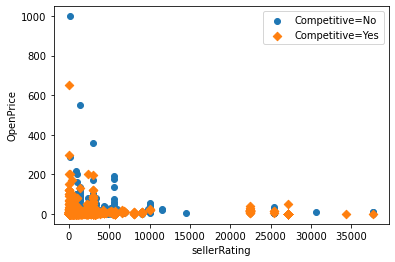

In [10]:
# plot sellerRating vs. OpenPrice 
fig, ax = plt.subplots()

subset = ebay_df.loc[ebay_df['Competitive']== 0]
ax.scatter(subset.sellerRating, subset.OpenPrice, marker='o', label='Competitive=No')

subset1 = ebay_df.loc[ebay_df['Competitive']== 1]
ax.scatter(subset1.sellerRating, subset1.OpenPrice, marker='D', label='Competitive=Yes')

plt.xlabel('sellerRating')  # set x-axis label
plt.ylabel('OpenPrice')  # set y-axis label
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

The splitting points are located way down in the lower left corner so the scatterplot does not reveal much to answer the question. We could do a log transform, or restrict the scatterplot to the smaller values.

In [11]:
# apply log transformation on the variables OpenPrice and sellerRating
train_df = train_X.copy()
train_df['Competitive'] = train_y
train_df['log_OpenPrice'] = np.log(train_df['OpenPrice'])
train_df['log_sellerRating'] = np.log(train_df['sellerRating'])

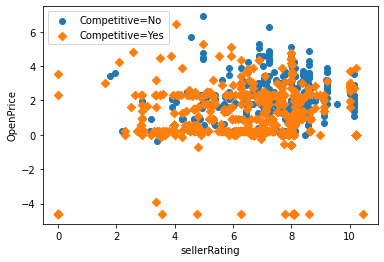

In [12]:
# plot sellerRating vs. OpenPrice 
fig, ax = plt.subplots()

subset = train_df.loc[train_df['Competitive']== 0]
ax.scatter(subset.log_sellerRating, subset.log_OpenPrice, marker='o', label='Competitive=No')

subset1 = train_df.loc[train_df['Competitive']== 1]
ax.scatter(subset1.log_sellerRating, subset1.log_OpenPrice, marker='D', label='Competitive=Yes')

plt.xlabel('sellerRating')  # set x-axis label
plt.ylabel('OpenPrice')  # set y-axis label
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)


Although it is hard to see a clear separation between the competitive and noncompetitive auctions on the scatter plot, we see a set of competitive auctions with opening price > 10 held by sellers with rating < 1000. This is surprising, because we would expect higher seller ratings to be associated with a higher chance of competitive auctions. We also see that the bulk of auctions with opening price < $1 or so are competitive, and this is not surprising (lower opening bids attract bidders).

__9.1.f.__ Examine the lift chart and the confusion matrix for the tree. What can you say about the predictive performance of this model?

__Answer:__ 

In [13]:
# predicted classes
pred_t = smallClassTree1.predict(train_X1)
pred_v = smallClassTree1.predict(valid_X1)

# predicted probabilities for validation set
pred_prob_v = (smallClassTree1.predict_proba(valid_X1))

# put it together in a data frame
tree_result = pd.DataFrame({'actual': valid_y1,
                           'p(0)': [p[0] for p in pred_prob_v],
                           'p(1)': [p[1] for p in pred_prob_v],
                           'predicted': pred_v})
tree_result.head()

,actual,p(0),p(1),predicted
1287,0,0.711340,0.288660,0
1017,1,0.270567,0.729433,1
1047,0,0.711340,0.288660,0
108,1,0.270567,0.729433,1
1084,1,0.711340,0.288660,0


In [14]:
# confusion matrices for training and validation sets
print('Training Set: Confusion matrix\n')
classificationSummary(train_y1, pred_t)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(valid_y1, pred_v)

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.7058)

       Prediction
Actual   0   1
     0 345 208
     1 140 490

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.7072)

       Prediction
Actual   0   1
     0 228 125
     1 106 330


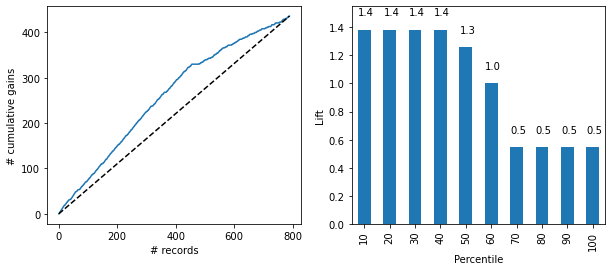

In [15]:
# lift chart for validation set
df = tree_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])

From the lift chart we see that the model's predictive performance (i.e. correctly capturing the auctions that are most likely to be competitive) is better than the baseline model, since its lift curve is higher than that of the baseline model. The decile lift chart has a limited set of lift values because the tree is a simple one, producing only three potential predicted probabilities.

__9.1.g.__ Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids and its relationship to the auction settings set by the seller (duration, opening price, ending day, currency)? What would you recommend for a seller as the strategy that will most likely lead to a competitive auction?

__Answer:__

To get a competitive auction, the most important factor controlled by the seller is the opening price, with lower opening prices attracting more bidders. From the tree we see that if the opening price < \\$3.615, then it will lead to a competitive auction. In particular, it appears that setting the opening price to the minimum of $0.01 (which is eBay's default) is most likely to lead to a competitive auction.

# Problem 9.2 Predicting Delayed Flights. 

The file _FlightDelays.csv_ contains information on all commercial flights departing the Washington, DC area and arriving at New York during January 2004. For each flight, there is information on the departure and arrival airports, the distance of the route, the scheduled time and date of the flight, and so on. The variable that we are trying to predict is whether or not a flight is delayed. A delay is defined as an arrival that is at least 15 minutes later than scheduled.

__Data Preprocessing.__ Transform variable day of week (DAY_WEEK) info a categorical variable. Bin the scheduled departure time into eight bins. Use these and all other columns as predictors (excluding DAY_OF_MONTH). Partition the data into training (60%) and validation (40%) sets.

## Data Preprocessing

In [16]:
# Load the data
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [17]:
# convert variable DAY_WEEK to categorical data type
delays_df['DAY_WEEK'].astype('category')

0       4
1       4
2       4
3       4
4       4
       ..
2196    6
2197    6
2198    6
2199    6
2200    6
Name: DAY_WEEK, Length: 2201, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [18]:
# bin CRS_DEP_TIME variable into 8 bins
delays_df['binned_CRS_DEP_TIME'] = pd.cut(delays_df.CRS_DEP_TIME, 8, labels=False)
delays_df['binned_CRS_DEP_TIME'].astype('category')

0       4
1       5
2       3
3       5
4       2
       ..
2196    0
2197    5
2198    5
2199    3
2200    5
Name: binned_CRS_DEP_TIME, Length: 2201, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [19]:
# remove DAY_OF_MONTH variable
predictors_df = delays_df
columns = list(delays_df.columns)
columns.remove('DAY_OF_MONTH')
predictors_df = predictors_df[columns]

__9.2.a.__ Fit a classification tree to the flight delay variable using all the relevant predictors. Do not include DEP_TIME (actual departure time) in the model because it is unknown at the time of prediction (unless we are generating our predictions of delays after the plane takes off, which is unlikely). Use a tree with maximum depth 8 and minimum impurity decrease = 0.01. Express the resulting tree as a set of rules.

In [20]:
# select only those variables which can be used for predicting the outcome.
# create a new dataframe with predictors
columns = list(predictors_df.columns)
columns

columns.remove('CRS_DEP_TIME')
columns.remove('DEP_TIME')
columns.remove('FL_DATE')
columns.remove('FL_NUM')
columns.remove('TAIL_NUM')
columns.remove('Flight Status')
predictors_df = predictors_df[columns]
predictors_df.columns

predictors_df.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,binned_CRS_DEP_TIME
0,OH,JFK,184,BWI,0,4,4
1,DH,JFK,213,DCA,0,4,5
2,DH,LGA,229,IAD,0,4,3
3,DH,LGA,229,IAD,0,4,5
4,DH,LGA,229,IAD,0,4,2


In [21]:
# create dummies for categorical variables
predictors_df = pd.get_dummies(predictors_df, prefix_sep='_')
predictors_df.columns

Index(['DISTANCE', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [22]:
# partition the data into training (60%) and validation (40%) sets. set random_state=1 for the reproducibility of results
X = predictors_df
y = delays_df['Flight Status']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()

,DISTANCE,Weather,DAY_WEEK,binned_CRS_DEP_TIME,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
1215,229,0,7,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1476,214,0,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1897,214,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
83,214,0,5,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1172,213,0,6,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [23]:
# fit the tree model and draw tree
smallClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

print('Tree has {} nodes'.format(smallClassTree.tree_.node_count))
plotDecisionTree(smallClassTree, feature_names=train_X.columns)

Tree has 3 nodes


'You need to install pydotplus to visualize decision trees'

The limited tree has only one splitting variable: Weather

If (Weather <= 0.5) then classify as Ontime.

__9.2.b.__ If you needed to fly between DCA and EWR on a Monday at 7:00 AM, would you be able to use this tree? What other information would you need? Is it available in practice? What information is redundant?

__Answer:__ 

We cannot use this tree, because we must know the Weather. The redundant information is the day of week (Monday) and arrival airport (EWR). The tree requires knowing whether the weather was inclement or not. We may not know the weather in advance.

__9.2.c.__ Fit the same tree as in (a), this time excluding the Weather predictor. Display both the resulting (small) tree and the full-grown tree. You will find that the small tree contains a single terminal node.

In [24]:
# remove variable Weather from the analysis
predictors1_df = predictors_df
columns = list(predictors_df.columns)
columns
columns.remove('Weather')
predictors1_df = predictors1_df[columns]
predictors1_df.columns

Index(['DISTANCE', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [25]:
X1 = predictors1_df
y1 = delays_df['Flight Status']

train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)

# full-grown tree
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X1, train_y1)

print('Tree has {} nodes'.format(fullClassTree.tree_.node_count))
plotDecisionTree(fullClassTree, feature_names=train_X1.columns)

Tree has 591 nodes


'You need to install pydotplus to visualize decision trees'

In [26]:
# small tree
ClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_impurity_decrease=0.01)
ClassTree.fit(train_X1, train_y1)

print('Tree has {} nodes'.format(ClassTree.tree_.node_count))
plotDecisionTree(ClassTree, feature_names=train_X1.columns)

Tree has 1 nodes


'You need to install pydotplus to visualize decision trees'

__9.2.c.i.__ How is the small tree used for classification? (What is the rule for classifying?)

__Answer:__ 

In the small tree we get a single terminal node labeled "ontime." Therefore any new flight will be classified as being "on time".

__9.2.c.ii__ To what is this rule equivalent?

__Answer:__

This is equivalent to the naïve rule, which is the majority rule. In this dataset most of the flights arrived on time, and therefore the naïve rule is to classify a new flight as arriving on time.

__9.2.c.iii.__ Examine the full-grown tree. What are the top three predictors according to this tree?

__Answer:__

CARRIER=US, CARRIER=DL, binned_CRS_DEP_TIME.

__9.2.c.iv.__ Why, technically, does the small tree result in a single node?

__Answer:__

The small tree results in a single node because adding splits would violate one of the constraints we used to limit tree growth. 

__9.2.c.v.__ What is the disadvantage of using the top levels of the full-grown tree as opposed to the small tree?

__Answer:__

Simply using the top layers of the full decision tree would be an ad hoc visual approach, and does not assure an optimal solution. Using "gridsearchCV" in Python allows us to set the parameters for limiting tree growth by assessing error on the validation data. We did not use "gridsearchCV" in this case, opting to keep the problem simple by specifying the limiting parameters.

__9.2.c.vi.__ Compare this general result to that from logistic regression in the example in Chapter 10. What are possible reasons for the classification tree’s failure to find a good predictive model?

In [27]:
# predictive power of tree
# predicted values for validation set
pred_v = ClassTree.predict(valid_X1)
# confusion matrix for validation set
classificationSummary(valid_y1, pred_v)

Confusion Matrix (Accuracy 0.8104)

       Prediction
Actual   0   1
     0   0 167
     1   0 714


The logistic regression improves only marginally on the naive rule, and the simple tree we ended up with improves on it not at all, so it is likely that the predictor variables offer little predictive power. With poor predictive power and a relatively small dataset, the model-based logistic regression may do a bit better by virtue of imposing structure, as opposed to the tree, which is more at the mercy of the data and can suffer from instability.

# Problem 9.3 Predicting Prices of Used Cars (Regression Trees). 

The file _ToyotaCorolla.csv_ contains the data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifications. The goal is to predict the price of a used Toyota Corolla based on its specifications. (The example in Section 9.7 is a subset of this dataset).

__Data Preprocessing.__ Split the data into training (60%), and validation (40%) datasets.

__9.3.a.__ Run a full-grown regression tree (RT) with outcome variable Price and predictors Age_08_04, KM, Fuel_Type (first convert to dummies), HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar. Set random_state=1.

__9.3.a.i.__ Which appear to be the three or four most important car specifications for predicting the car’s price?

In [28]:
# Load the data
car_df = pd.read_csv(DATA / 'ToyotaCorolla.csv')

# Select the required columns
columns = ['Price', 'Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 
           'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 
           'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 
           'Sport_Model', 'Tow_Bar']

car_df = car_df[columns]

# Convert Fuel_Type to dummy variables
car_df = pd.get_dummies(car_df, drop_first=True)

# Make sure that the result is as expected
car_df.head()

,Price,Age_08_04,KM,HP,Automatic,Doors,Quarterly_Tax,Mfr_Guarantee,Guarantee_Period,Airco,Automatic_airco,CD_Player,Powered_Windows,Sport_Model,Tow_Bar,Fuel_Type_Diesel,Fuel_Type_Petrol
0,13500,23,46986,90,0,3,210,0,3,0,0,0,1,0,0,1,0
1,13750,23,72937,90,0,3,210,0,3,1,0,1,0,0,0,1,0
2,13950,24,41711,90,0,3,210,1,3,0,0,0,0,0,0,1,0
3,14950,26,48000,90,0,3,210,1,3,0,0,0,0,0,0,1,0
4,13750,30,38500,90,0,3,210,1,3,1,0,0,1,0,0,1,0


In [29]:
# separate out predictors and outcome variable
X = car_df.drop(columns='Price')
y = car_df['Price']

# partition the data into training (60%) and validiation (40%). Set random_state=1 for reproducibility of results 
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (861, 16) Validation set: (575, 16)


In [30]:
# setting random state will ensure that the same tree is produced every time
deepTree = DecisionTreeRegressor(random_state=1)
deepTree.fit(train_X, train_y)

print('Tree has {} nodes'.format(deepTree.tree_.node_count))
plotDecisionTree(deepTree, feature_names=train_X.columns, impurity=False)

Tree has 1485 nodes


'You need to install pydotplus to visualize decision trees'

In [31]:
# Variable importance
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': deepTree.feature_importances_})
importance.sort_values(by='importance', ascending=False)

,features,importance
0,Age_08_04,0.844867
2,HP,0.053789
1,KM,0.049601
9,Automatic_airco,0.013358
5,Quarterly_Tax,0.006769
11,Powered_Windows,0.005221
4,Doors,0.004864
8,Airco,0.004727
12,Sport_Model,0.004459
6,Mfr_Guarantee,0.003714


From the regression tree it appears that the most important car specifications to predict the car's price are Age_08_04 (Age in months as of August 2004), HP (Horse Power), KM (accumulated kilometers on odometer) and Automatic_airco (Automatic Airconditioning(Yes=1, No=0)).

__Note:__ It has been pointed out that there is a value in the cc variable - 16,000 - that is probably a data input error. The solutions have been prepared without correcting this error, but a solution that includes correcting this error to 1600 would also be fine. (The data could also be used as a small illustration or exercise of data prep and cleaning.)

__9.3.a.ii.__ Compare the prediction errors of the training and validation sets by examining their RMS error and by plotting the two boxplots. How does the predictive performance of the validation set compare to the training set? Why does this occur?

__Answer:__

In [32]:
# error report for training and validation sets
print('training set:')
regressionSummary(train_y, deepTree.predict(train_X))
print('\nvalidation set:')
regressionSummary(valid_y, deepTree.predict(valid_X))

training set:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000

validation set:

Regression statistics

                      Mean Error (ME) : 76.6557
       Root Mean Squared Error (RMSE) : 1492.3365
            Mean Absolute Error (MAE) : 1152.4852
          Mean Percentage Error (MPE) : -0.3363
Mean Absolute Percentage Error (MAPE) : 11.3783


The RMSE of the training set is 0 since the tree is as complex as it can be and fully predicts every record. The RMSE of the validation set, which was not involved in the overfitting, is about 1500.

__9.3.a.iii.__ How might we achieve better validation predictive performance at the expense of training performance?

__Answer:__

By limiting tree growth with GridSearchCV, which assesses the performance of many different tree sizes.

__9.3.a.iv.__ Create a smaller tree by using GridSearchCV() with cv=5 to find a fine-tuned tree. Compared to the full-grown tree, what is the predictive performance on the validation set?

In [33]:
# Before doing full grid search, try a tree of depth = 5
# smaller tree
shallowTree = DecisionTreeRegressor(max_depth=5)
shallowTree.fit(train_X, train_y)
print('Tree has {} nodes'.format(shallowTree.tree_.node_count))
plotDecisionTree(shallowTree, feature_names=train_X.columns, rotate=True, impurity=False)

Tree has 59 nodes


'You need to install pydotplus to visualize decision trees'

In [34]:
# error report for training and validation sets
print('training set:')
regressionSummary(train_y, shallowTree.predict(train_X))
print('\nvalidation set:')
regressionSummary(valid_y, shallowTree.predict(valid_X))

training set:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1028.0279
            Mean Absolute Error (MAE) : 773.2770
          Mean Percentage Error (MPE) : -1.0039
Mean Absolute Percentage Error (MAPE) : 7.6715

validation set:

Regression statistics

                      Mean Error (ME) : 67.4074
       Root Mean Squared Error (RMSE) : 1147.5478
            Mean Absolute Error (MAE) : 903.1033
          Mean Percentage Error (MPE) : -0.5786
Mean Absolute Percentage Error (MAPE) : 9.1916


For the shallower tree, the RMSE values of training and validation sets are comparable. Compared to the deep tree, the RMSE of the validation set is lower. This shallower tree does much worse on the training set than the deep tree but does better in predicting rows in the validation set. This indicates a more robust model.

In [35]:
# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 
                              0.006, 0.007], 
    'min_samples_split': [17, 18, 19, 20, 21, 22, 23], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

optRegTree = gridSearch.best_estimator_

importanceRT = pd.DataFrame({'features': train_X.columns, 
                             'importance': deepTree.feature_importances_})

print('Tree has {} nodes'.format(optRegTree.tree_.node_count))
plotDecisionTree(optRegTree, feature_names=train_X.columns, rotate=True)

Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}


Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 21}
Tree has 61 nodes


'You need to install pydotplus to visualize decision trees'

In [36]:
# error report for training and validation sets
print('training set:')
regressionSummary(train_y, optRegTree.predict(train_X))
print('\nvalidation set:')
regressionSummary(valid_y, optRegTree.predict(valid_X))

training set:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1100.9381
            Mean Absolute Error (MAE) : 799.4101
          Mean Percentage Error (MPE) : -1.0081
Mean Absolute Percentage Error (MAPE) : 7.6852

validation set:

Regression statistics

                      Mean Error (ME) : 23.7040
       Root Mean Squared Error (RMSE) : 1240.2015
            Mean Absolute Error (MAE) : 950.0088
          Mean Percentage Error (MPE) : -1.0616
Mean Absolute Percentage Error (MAPE) : 9.5168


__9.3.b.__ Let us see the effect of turning the price variable into a categorical variable. First, create a new variable that categorizes price into 20 bins. Now repartition the data keeping Binned_Price instead of Price. Run a classification tree with the same set of input variables as in the RT, and with Binned_Price as the output variable. As in the less deep regression tree, create a smaller tree by using GridSearchCV() with cv=5 to find a fine-tuned tree.

In [37]:
# categorical price
car_df['binned_price'] = pd.cut(car_df.Price, 20, labels=False)
car_df.head(5)

# separate out predictors and response
X = car_df.drop(columns=['Price', 'binned_price'])
y = car_df['binned_price']

# partition the data into training (60%) and validation (40%). Set random_state=1 for the reproducibility of results
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

__9.3.b.i.__ Compare the smaller tree generated by the CT with the smaller tree generated by RT. Are they different? (Look at structure, the top predictors, size of tree, etc.) Why?

__Answer:__

In [38]:
# use grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    'min_samples_split': [8, 9, 10, 11, 12, 13], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

optClassTree = gridSearch.best_estimator_
importanceCT = pd.DataFrame({'features': train_X.columns, 
                             'importance': optClassTree.feature_importances_})


Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}


Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 12}


In [39]:
# plot the tree
# CT has 57 nodes, compared to RT, which has 61
print('Tree has {} nodes'.format(optClassTree.tree_.node_count))
plotDecisionTree(optClassTree, feature_names=train_X.columns, rotate=True)

Tree has 57 nodes


'You need to install pydotplus to visualize decision trees'

In [40]:
# error report for trainig and validation sets
print('training set:')
classificationSummary(train_y, optClassTree.predict(train_X))
print('\nvalidation set:')
classificationSummary(valid_y, optClassTree.predict(valid_X))

training set:
Confusion Matrix (Accuracy 0.5738)

       Prediction
Actual   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
     0   0   2   0   1   0   1   0   0   0   0   0   0   0   0   0   0   0
     1   0  22  38   2   0   0   0   0   0   0   0   0   0   0   0   0   0
     2   0   7 121  51   0   0   0   0   0   0   0   0   0   0   0   0   0
     3   0   1  42 197   4   7   0   0   0   0   0   0   0   0   0   0   0
     4   0   0   3  63  21  21   1   0   0   0   0   0   0   0   0   0   0
     5   0   0   0  14   4  52  13   0   0   0   0   0   0   0   0   0   0
     6   0   0   0   4   0  17  32   0   2   0   0   3   0   0   0   0   0
     7   0   0   0   0   0   2   9   0   2   0   1   0   0   0   0   0   0
     8   0   0   0   0   0   0   0   0  25   0   4   3   0   0   0   0   0
     9   0   0   0   0   0   0   0   0   4   4   3   2   0   0   0   0   0
    10   0   0   0   1   0   0   0   0   4   0  15   3   0   0   0   0   0
    11   0   0   0   0   0   0  

The accuracies for the shallow classification tree are 0.57 and 0.48.

The cross validation results suggest to pick a maximum tree depth of 5. At this depth, the accuracy on the training (0.57) and validation sets (0.48) are comparable.

In [41]:
# variable importance for regression tree
importanceRT.sort_values(by='importance', ascending=False).head(5)

,features,importance
0,Age_08_04,0.844867
2,HP,0.053789
1,KM,0.049601
9,Automatic_airco,0.013358
5,Quarterly_Tax,0.006769


In [42]:
# variable importance for classification tree
importanceCT.sort_values(by='importance', ascending=False).head(5)

,features,importance
0,Age_08_04,0.614901
1,KM,0.193525
5,Quarterly_Tax,0.043403
11,Powered_Windows,0.039055
8,Airco,0.029699


__9.3.b.ii.__ Predict the price, using the smaller RT and CT, of a used Toyota Corolla with the specifications listed in Table 9.10.

__Answer:__

In [43]:
# used car
useCar_df = pd.DataFrame([{
    'Age_08_04': 77,
    'KM': 117000, 
    'Petrol': 1,
    'Diesel': 0,
    'HP': 110, 
    'Automatic': 0, 
    'Doors': 5, 
    'Quarterly_Tax': 100,
    'Mfr_Guarantee': 0, 
    'Guarantee_Period': 3, 
    'Airco': 1, 
    'Automatic_airco': 0,  
    'CD_Player': 0, 
    'Powered_Windows': 0, 
    'Sport_Model': 0, 
    'Tow_Bar': 1 
}])
optRegTree.predict(useCar_df)

print(optClassTree.predict(useCar_df))
pd.cut(car_df.Price, 20).cat.categories[optClassTree.predict(useCar_df)]

[3]


IntervalIndex([(8572.5, 9980.0]],
              closed='right',
              dtype='interval[float64]')

__9.3.b.iii.__ Compare the predictions in terms of the predictors that were used, the magnitude of the difference between the two predictions, and the advantages and disadvantages of the two methods.

__Answer:__

The optimal tree predicts the car price to be in bin 2 which corresponds to a price range of 7165 to 8572. 

From the classification tree we get a range for the predicted price whereas the regression tree gives a predicted fixed price.

The advantage of CT is that it is simpler and therefore more robust, but you do lose accuracy by binning the price. So depending on the application, RT or CT would be selected.

For example, if your purpose were simply to set an initial sticker price at which to sell the car (i.e., estimation), RT would be a good choice. On the other hand, if your purpose were to determine whether the car falls above or below a set cutoff (say, for inclusion in an offering to a volume buyer who will not pay more than a certain amount per car), CT will focus on developing rules for that particular price point and might work better.